In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np
import soundfile as sf
import sys
from torch.utils.data import Dataset, DataLoader, random_split
sys.path.insert(0, r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\AudioDataset")

from AudioDataset import AudioDataset, pad_collate_fn

In [2]:
# Filepaths
root_dir = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\train\train\audio"
cache_dir = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\cache_spectrograms"
export_dir = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\spectrograms"
os.makedirs(cache_dir, exist_ok=True)

In [5]:
dataset = AudioDataset(
    root_dir        = root_dir,
    cache_dir       = cache_dir,
    export_dir      = None,
    preprocess      = True,              
    transform       = None,              
    allowed_classes = ["yes","no","up","down","left","right","on","off","stop","go"],
    save_spectrograms = False         
)

# EDA

In [6]:
records = []
for fp, label_idx in zip(dataset.filepaths, dataset.labels):
    data, sr = sf.read(fp)
    length_s = len(data) / sr
    max_amp = data.max()
    min_amp = data.min()
    abs_max = max(abs(min_amp), abs(max_amp))
    records.append({
        'filename': os.path.basename(fp),
        'label':        dataset.idx2label[label_idx],
        'length_s':     length_s,
        'max_amp':      max_amp,
        'min_amp':      min_amp,
        'abs_max':      abs_max
    })

df = pd.DataFrame(records)
print(df)

                    filename    label   length_s   max_amp   min_amp   abs_max
0      00176480_nohash_0.wav  unknown   1.000000  0.754852 -0.489471  0.754852
1      004ae714_nohash_0.wav  unknown   1.000000  0.388794 -0.348541  0.388794
2      004ae714_nohash_1.wav  unknown   0.928813  0.214264 -0.176910  0.214264
3      00f0204f_nohash_0.wav  unknown   1.000000  0.071014 -0.075500  0.075500
4      00f0204f_nohash_1.wav  unknown   1.000000  0.077423 -0.077118  0.077423
...                      ...      ...        ...       ...       ...       ...
67122      dude_miaowing.wav  unknown  61.805687  0.751770 -0.833984  0.833984
67123      exercise_bike.wav  unknown  61.253875  0.238464 -0.251495  0.251495
67124         pink_noise.wav  unknown  60.000000  0.999969 -0.999969  0.999969
67125        running_tap.wav  unknown  61.155500  0.714142 -0.877167  0.877167
67126        white_noise.wav  unknown  60.000000  0.999969 -0.999969  0.999969

[67127 rows x 6 columns]


In [42]:
# Stats

desc = df[['length_s','max_amp','min_amp','abs_max']].describe()
print("Stats:\n", desc)

Stats:
            length_s       max_amp       min_amp       abs_max
count  67127.000000  67127.000000  67127.000000  67127.000000
mean       0.990995      0.408207     -0.408983      0.446980
std        0.634426      0.294700      0.292890      0.304807
min        0.371563     -0.182098     -1.000000      0.000000
25%        1.000000      0.163864     -0.625366      0.188507
50%        1.000000      0.331024     -0.333099      0.374786
75%        1.000000      0.626572     -0.164948      0.710480
max       95.183125      0.999969      0.013519      1.000000


# Plot of max|amp|

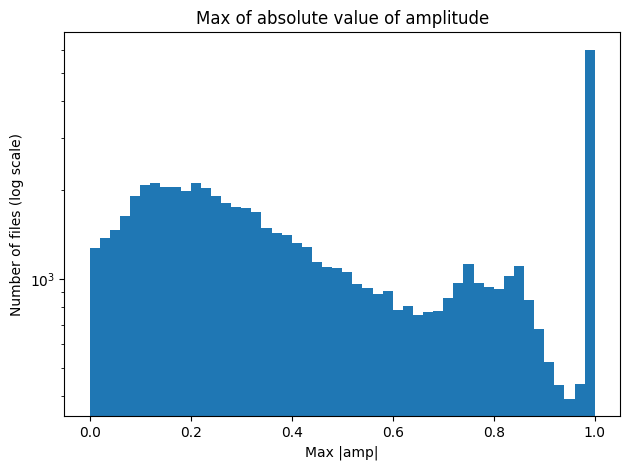

In [43]:
plt.figure()
plt.hist(df['abs_max'], bins=50, log=True)
plt.title('Max of absolute value of amplitude')
plt.xlabel('Max |amp|')
plt.ylabel('Number of files (log scale)')
plt.tight_layout()
plt.show()

In [44]:
# Outliers base on rule: max|amp| > 1.5*IQR to outlier

iqr = desc.loc['75%', 'abs_max'] - desc.loc['25%', 'abs_max']
threshold = desc.loc['75%', 'abs_max'] + 1.5 * iqr
outliers = df[df['abs_max'] > threshold]
print(f"\nOutliers (abs_max > {threshold:.3f}):")
print(outliers[['filename','label','abs_max']])


Outliers (abs_max > 1.493):
Empty DataFrame
Columns: [filename, label, abs_max]
Index: []


Most files have a moderate loudness level, however there are about 5000 files with an amplitude of around 1.0, but they do not exceed the threshold of 1.5*IQR so we do not consider them outliers.

# Class counts


Number of files in classes:
label
unknown    43445
stop        2380
yes         2377
no          2375
up          2375
go          2372
on          2367
right       2367
down        2359
off         2357
left        2353
Name: count, dtype: int64


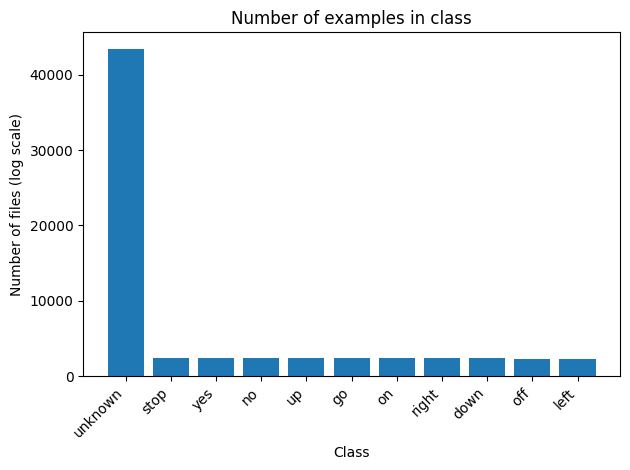

In [45]:
class_counts = df['label'].value_counts()
print("\nNumber of files in classes:")
print(class_counts)

plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.title('Number of examples in class')
plt.xlabel('Class')
plt.ylabel('Number of files (log scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The largest class is unknown, the rest are of similar size, to balance it we will use undersampling.

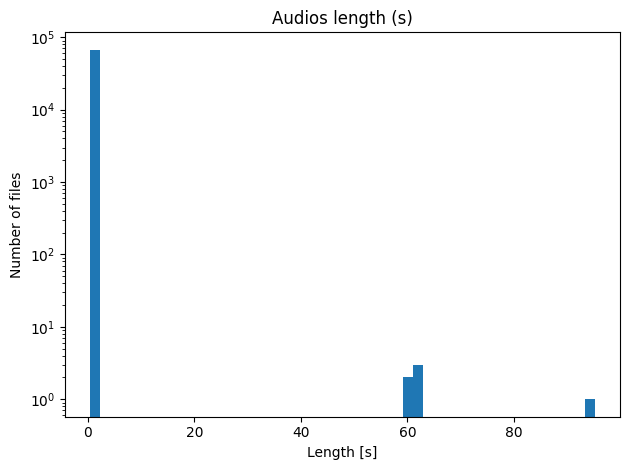

In [11]:
plt.figure()
plt.hist(df['length_s'], bins=50, log = True)
plt.title('Audios length (s)')
plt.xlabel('Length [s]')
plt.ylabel('Number of files')
plt.tight_layout()
plt.show()

Most recordings are approx. 1 sec long, there are a few much longer.

In [46]:
# Printing recordings longer than 1
long_records = df[df['length_s'] > 1]
print(long_records)

                   filename    label   length_s   max_amp   min_amp   abs_max
67121  doing_the_dishes.wav  unknown  95.183125  0.875580 -0.939911  0.939911
67122     dude_miaowing.wav  unknown  61.805687  0.751770 -0.833984  0.833984
67123     exercise_bike.wav  unknown  61.253875  0.238464 -0.251495  0.251495
67124        pink_noise.wav  unknown  60.000000  0.999969 -0.999969  0.999969
67125       running_tap.wav  unknown  61.155500  0.714142 -0.877167  0.877167
67126       white_noise.wav  unknown  60.000000  0.999969 -0.999969  0.999969


# Spectrograms

C:\Users\monik\AppData\Local\Temp\ipykernel_24260\3796839427.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


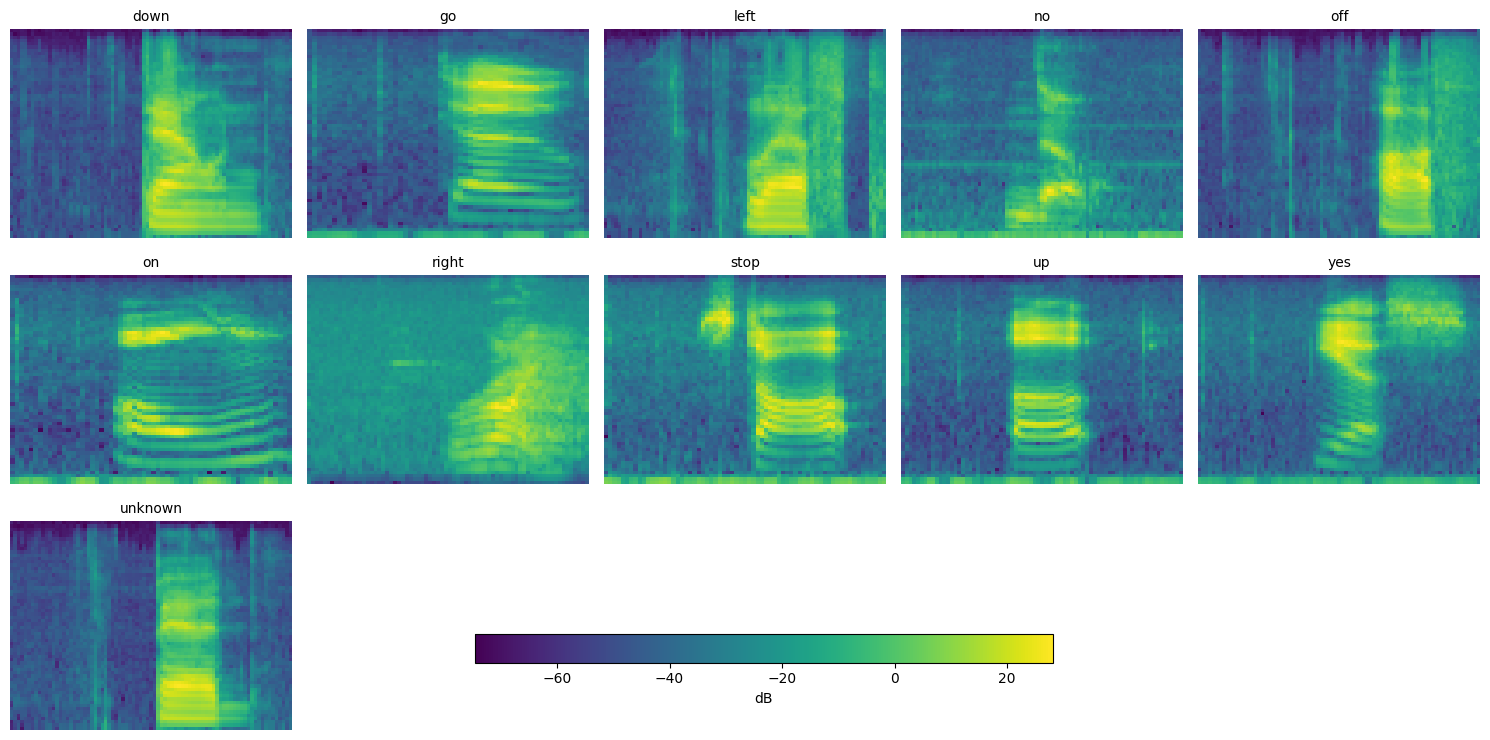

In [47]:
# Getting one example from each class
seen = set()
example_idxs = {}
for idx, label in enumerate(dataset.labels):
    if label not in seen:
        seen.add(label)
        example_idxs[label] = idx
    if len(seen) == len(dataset.label2idx):
        break

# Number of classes and subplot grid
n_classes = len(example_idxs)
cols = 5
rows = (n_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5))
axes = axes.flatten()

for ax_i, (label, idx) in enumerate(sorted(example_idxs.items())):
    spec_db, _ = dataset[idx]
    im = axes[ax_i].imshow(
        spec_db.squeeze(0).numpy(),
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    axes[ax_i].set_title(dataset.idx2label[label], fontsize=10)
    axes[ax_i].axis('off')

# Removing empty axes
for ax in axes[n_classes:]:
    ax.remove()

# Common colorbar
cbar = fig.colorbar(im, ax=axes[:n_classes], orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('dB')

plt.tight_layout()
plt.show()

# Speakers

In [48]:
# Validation filepath
val_list_path = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\train\train\validation_list.txt"

In [49]:
def count_speakers_in_dir(directory):
    """Counts WAV files in each class according to speakers' ID"""
    cnt = Counter()
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for fname in os.listdir(label_dir):
            if not fname.lower().endswith(".wav"):
                continue
            speaker = fname.split("_", 1)[0]
            cnt[speaker] += 1
    return cnt

def count_speakers_from_list(root, list_path):
    """Counts files according to filepaths in list_path"""
    cnt = Counter()
    with open(list_path, "r") as f:
        for rel in f:
            rel = rel.strip()
            if not rel:
                continue
            # rel = "label/filename.wav"
            _, fname = rel.split("/", 1)
            speaker = fname.split("_", 1)[0]
            cnt[speaker] += 1
    return cnt

In [50]:
# rain
train_counts = count_speakers_in_dir(root_dir)

# Validation
val_counts   = count_speakers_from_list(root_dir, val_list_path)

In [51]:
counts_train = list(train_counts.values())
counts_val   = list(val_counts.values())

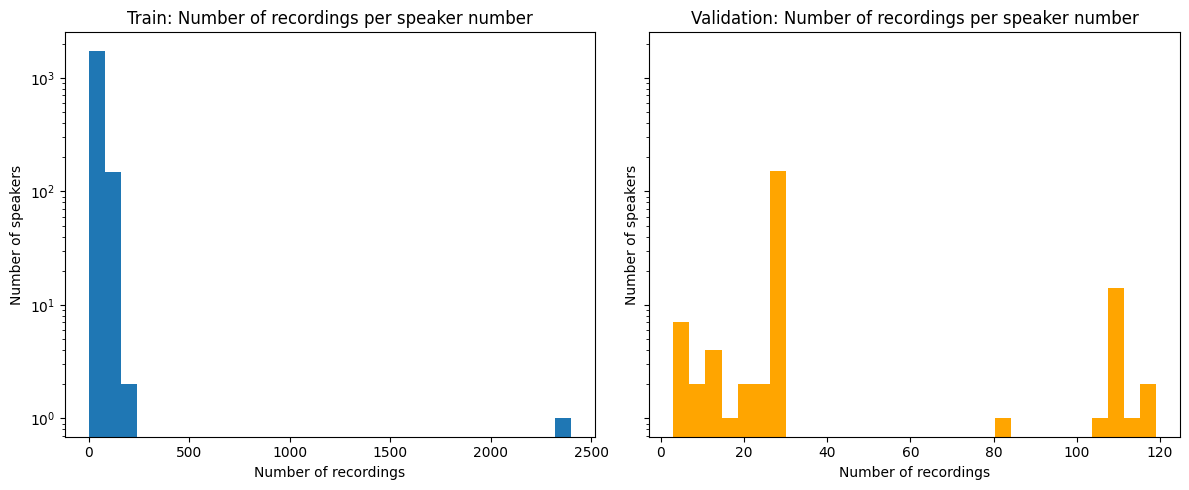

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Train
axes[0].hist(counts_train, bins=30, log = True)
axes[0].set_title("Train: Number of recordings per speaker number")
axes[0].set_xlabel("Number of recordings")
axes[0].set_ylabel("Number of speakers")

# Val
axes[1].hist(counts_val, bins=30, color='orange', log = True)
axes[1].set_title("Validation: Number of recordings per speaker number")
axes[1].set_xlabel("Number of recordings")
axes[1].set_ylabel("Number of speakers")

plt.tight_layout()
plt.show()

In [53]:
# Speakers in train
train_speakers = sorted(train_counts.keys())
print(f"Train ({len(train_speakers)} speakers).")
print("First 10 speakers:")
for sp in train_speakers[:10]:
    print(sp)

Train (1888 speakers).
First 10 speakers:
00176480
004ae714
00b01445
00f0204f
012c8314
0132a06d
0135f3f2
0137b3f4
014f9f65
01648c51


In [54]:
# Speakers in validation
val_speakers = sorted(val_counts.keys())
print(f"\nValidation ({len(val_speakers)} speakerów).")
print("First 10 speakers:")
for sp in val_speakers[:10]:
    print(sp)


Validation (189 speakerów).
First 10 speakers:
026290a7
060cd039
099d52ad
0ab3b47d
0e17f595
105e72bb
10f2bb12
1657c9fa
16db1582
171b56dc


In [55]:
print("Number of unique speakers in the train set:", len(train_counts))
print("Number of unique speakers in the validation set:", len(val_counts))

Number of unique speakers in the train set: 1888
Number of unique speakers in the validation set: 189


## Histogram of recordings per speaker

In [56]:
# Bins for histograms
base_bins = [1, 10, 25, 50, 100, 125, 150]
max_edge = np.array(counts_train).max() + 1
bins = sorted(set(base_bins + [max_edge]))

In [57]:
# Training set

# Histogram
hist_train, edges_train = np.histogram(counts_train, bins=bins)

# Bins and number of speakers in each bin
for i in range(len(hist_train)):
    low = edges_train[i]
    high = edges_train[i+1] - 1
    print(f"{int(low):>4}–{int(high):>4} recordings: {hist_train[i]:>5} speakers")

   1–   9 recordings:   112 speakers
  10–  24 recordings:    72 speakers
  25–  49 recordings:  1548 speakers
  50–  99 recordings:     7 speakers
 100– 124 recordings:   143 speakers
 125– 149 recordings:     1 speakers
 150–2400 recordings:     5 speakers


In [58]:
# Validation set

# Histogram
hist_val, edges_val = np.histogram(counts_val, bins=bins)

# Bins and number of speakers in each bin
for i in range(len(hist_val)):
    low = edges_val[i]
    high = edges_val[i+1] - 1
    print(f"{int(low):>4}–{int(high):>4} recordings: {hist_val[i]:>5} speakers")

   1–   9 recordings:     9 speakers
  10–  24 recordings:     9 speakers
  25–  49 recordings:   152 speakers
  50–  99 recordings:     1 speakers
 100– 124 recordings:    18 speakers
 125– 149 recordings:     0 speakers
 150–2400 recordings:     0 speakers


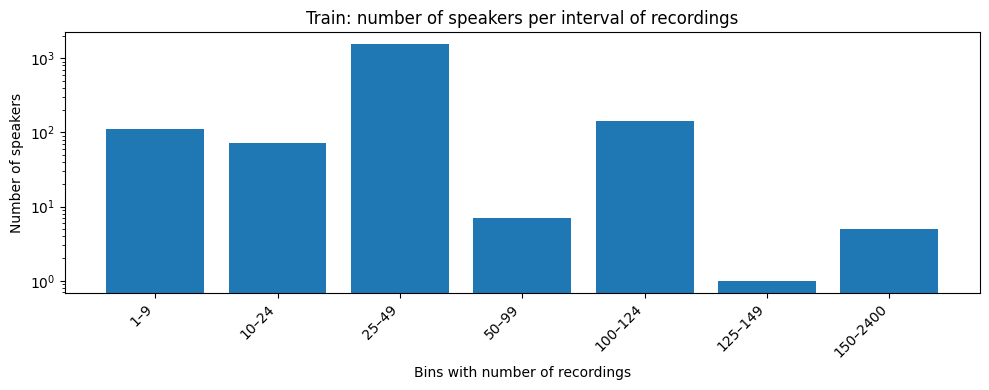

In [59]:
labels_train = [f"{int(edges_train[i])}–{int(edges_train[i+1]-1)}" for i in range(len(hist_train))]

plt.figure(figsize=(10,4))
plt.bar(labels_train, hist_train)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.title("Train: number of speakers per interval of recordings")
plt.xlabel("Bins with number of recordings")
plt.ylabel("Number of speakers")
plt.tight_layout()
plt.show()

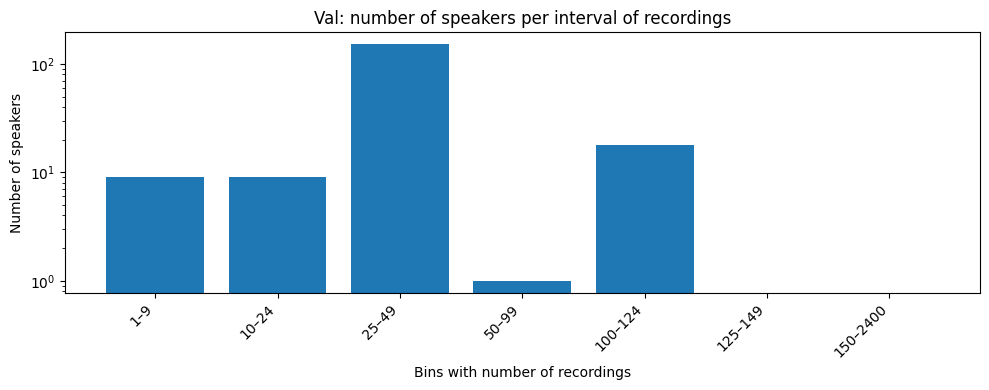

In [60]:
labels_val = [f"{int(edges_val[i])}–{int(edges_val[i+1]-1)}" for i in range(len(hist_val))]

plt.figure(figsize=(10,4))
plt.bar(labels_val, hist_val)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.title("Val: number of speakers per interval of recordings")
plt.xlabel("Bins with number of recordings")
plt.ylabel("Number of speakers")
plt.tight_layout()
plt.show()

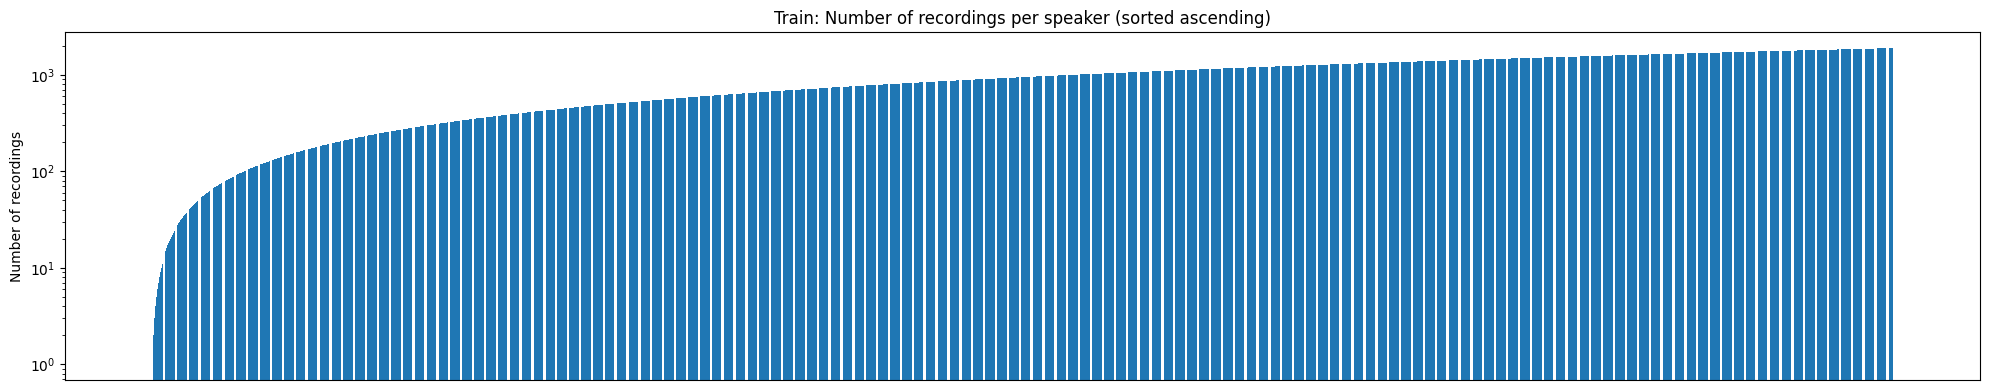

In [61]:
# zip and sort by count
pairs = sorted(zip(train_speakers, train_counts), key=lambda x: x[1])
sorted_speakers, sorted_counts = zip(*pairs)


plt.figure(figsize=(20,4))
plt.bar(range(len(sorted_speakers)), sorted_counts)
plt.yscale('log')
plt.title("Train: Number of recordings per speaker (sorted ascending)")
plt.ylabel("Number of recordings")
plt.xticks([], [])
plt.tight_layout()
plt.show()

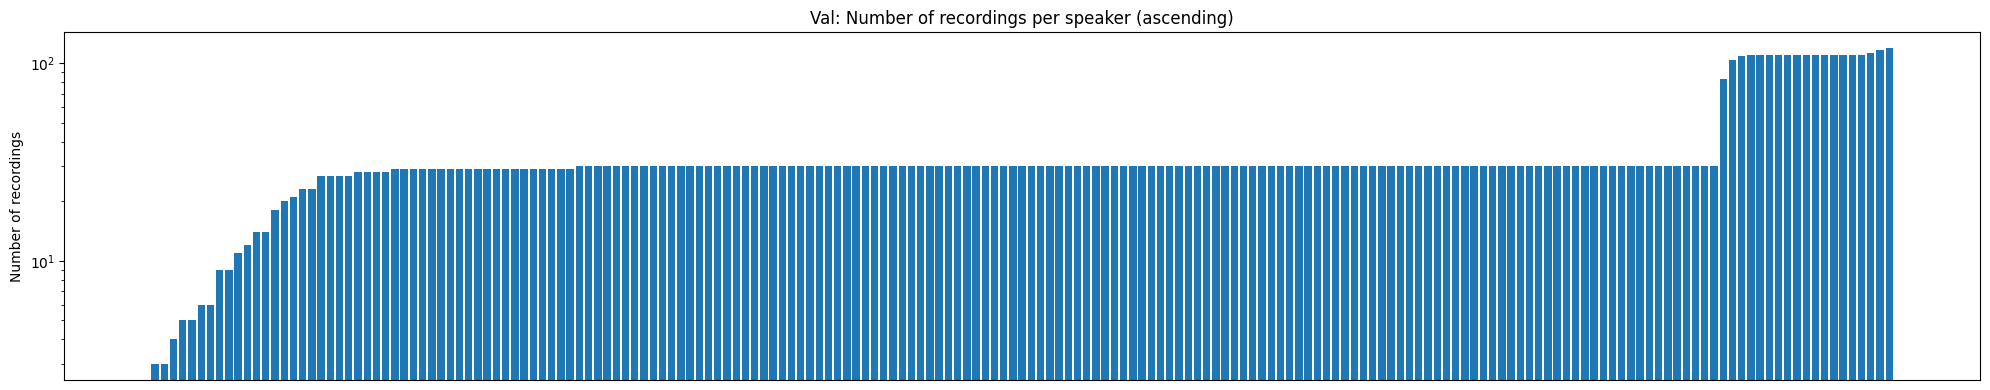

In [62]:
val_speakers = list(val_counts.keys())
val_counts   = list(val_counts.values())

# zip and sort by count
val_pairs = sorted(zip(val_speakers, val_counts), key=lambda x: x[1])
sorted_val_speakers, sorted_val_counts = zip(*val_pairs)

plt.figure(figsize=(20, 4))
plt.bar(range(len(sorted_val_speakers)), sorted_val_counts)
plt.yscale('log')  
plt.title("Val: Number of recordings per speaker (ascending)")
plt.ylabel("Number of recordings")
plt.xticks([], []) 
plt.tight_layout()
plt.show()

# Speakers in both training and validation sets

In [63]:
common_speakers = set(train_speakers).intersection(set(val_speakers))

print(f"Number of common speakers: {len(common_speakers)}.")
print("First 10 common speakers:")
for speaker in sorted(common_speakers)[:10]:
    print(speaker)


Number of common speakers: 189.
First 10 common speakers:
026290a7
060cd039
099d52ad
0ab3b47d
0e17f595
105e72bb
10f2bb12
1657c9fa
16db1582
171b56dc


When splitting data into training and validation datasets we will make sure that speakers in validation dataset are different from speakers in training set.